# CIVENG 299 Fall 2022

@ author Juanwu Lu

@ date   Sep-05-22

&copy; UC Berkeley

---

In [1]:
import os
from datetime import datetime
from IPython.display import display
from os import path as osp

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import ndarray
from pandas import DataFrame

In [2]:
CSV_TYPE = {
    "xd_id": np.uint32,
    # "measurement_tstamp": datetime,
    "speed": np.float32,
    "average_speed": np.float32,
    "reference_speed": np.float32,
    "travel_time_seconds": np.float32,
    "confidence_score": np.float32,
    "cvalue": np.float32,
}
SEQUENCE = [1524495872, 1524270742, 1524323951, 1524323973, 1524323903,
            1524584569, 1524475747, 1524475699, 1524318097, 1524553047,
            1524552976, 1524552999, 461634577, 461626140, 461629140,
            396160294, 1524313670, 1524313621, 1524313548, 1524313572,
            429359943]

## Plotting

### Loading

In [5]:
df: DataFrame = pd.read_csv('data/inrix_raw_am.csv', sep=',',
                            encoding='utf-8', dtype=CSV_TYPE)
df['measurement_tstamp'] = pd.to_datetime(df['measurement_tstamp'])
display(df.head(5))

,xd_id,measurement_tstamp,speed,average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue
0,1524313548,2021-01-01 00:00:00,70.0,64.0,64.0,28.92,30.0,100.0
1,1524313548,2021-01-01 00:01:00,71.0,64.0,64.0,28.51,30.0,100.0
2,1524313548,2021-01-01 00:02:00,70.0,64.0,64.0,28.92,30.0,100.0
3,1524313548,2021-01-01 00:03:00,71.0,64.0,64.0,28.51,30.0,100.0
4,1524313548,2021-01-01 00:04:00,71.0,64.0,64.0,28.51,30.0,100.0


### Aggregation by Date

In [6]:
ref_td = df['measurement_tstamp'] - datetime(2021, 1, 1, 0, 0, 0)
df['seconds_in_day'] = ref_td.dt.seconds
df['date'] = df['measurement_tstamp'].dt.date
display(df.head(5))

,xd_id,measurement_tstamp,speed,average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,seconds_in_day,date
0,1524313548,2021-01-01 00:00:00,70.0,64.0,64.0,28.92,30.0,100.0,0,2021-01-01
1,1524313548,2021-01-01 00:01:00,71.0,64.0,64.0,28.51,30.0,100.0,60,2021-01-01
2,1524313548,2021-01-01 00:02:00,70.0,64.0,64.0,28.92,30.0,100.0,120,2021-01-01
3,1524313548,2021-01-01 00:03:00,71.0,64.0,64.0,28.51,30.0,100.0,180,2021-01-01
4,1524313548,2021-01-01 00:04:00,71.0,64.0,64.0,28.51,30.0,100.0,240,2021-01-01


Index(['Segments', 'measurement_tstamp', 'speed', 'average_speed',
       'reference_speed', 'travel_time_seconds', 'confidence_score', 'cvalue',
       'seconds_in_day', 'date'],
      dtype='object')


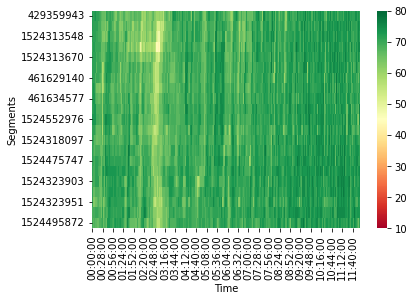

In [7]:
for date, g in df.groupby(by=['date']):
    g.rename(columns={'xd_id': 'Segments'}, inplace=True)
    print(g.columns)
    g['Time'] = pd.to_datetime(g['measurement_tstamp'], format='%H:%M:%S').dt.time
    speed_pivot = pd.pivot_table(data=g, columns='Time',
                                 index='Segments', values='speed')
    speed_pivot = speed_pivot.loc[SEQUENCE]
    ax = sns.heatmap(data=speed_pivot, cmap=plt.get_cmap('RdYlGn'), vmax=80, vmin=10)
    ax.invert_yaxis()
    break

---

## Graph Model

- __Design Ideas__
   - Graph Data
      - `x`: The average velocity of each segment at timestep $t$, the location embedding $l$.
      - `edge_index`: A coo-format connectivity matrix of shape `[2, num_edge]`. 
      - `edge_attr`: For propagation models, the attribute would be the distance; for update models, the attribute would be the time interval.
      - `y`: The average velocity of each segment at timestep $t+\delta$.
   - Model Design

In [128]:
import os
import pickle
from collections import OrderedDict
from os import path as osp
from typing import Any, Dict, List

import numpy as np
import pandas as pd
import torch as th
from numpy import ndarray
from pandas import DataFrame
from pandas.tseries.holiday import USFederalHolidayCalendar
from torch import Tensor
from torch_geometric.data import Batch, Data, HeteroData, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing

In [127]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Data Preprocessing

In [141]:
df = pd.read_csv('../data/raw/inrix_am.csv', sep=',',
                 encoding='utf-8', dtype=CSV_TYPE)
df['measurement_tstamp'] = pd.to_datetime(df['measurement_tstamp'])
ref_dt = df['measurement_tstamp'] - df['measurement_tstamp'].min()
holidays = USFederalHolidayCalendar()
holidays = holidays.holidays(
    start=df['measurement_tstamp'].min(), end=df['measurement_tstamp'].max()
)

df['date'] = df['measurement_tstamp'].dt.date
df['time'] = df['measurement_tstamp'].dt.time
df['minutes'] = ref_dt.dt.seconds / 60
df['is_holiday'] = df['measurement_tstamp'].isin(holidays)
df['is_holiday'] = df['is_holiday'].map({False: -1, True: 1})
df['graphs'] = ref_dt.dt.days
spatial_map: Dict[int, int] = {}
for i, xd_id in enumerate(SEQUENCE[::-1]):
    spatial_map[xd_id] = i
df['xd_order'] = df['xd_id'].map(spatial_map)
# df.sort_values(by=['date', 'xd_order', 'time'], inplace=True)
# df = df[['graphs', 'minutes', 'xd_order', 'speed', 'travel_time_seconds']]
# df.dropna(how='any', axis=0)
# df.reset_index(drop=True, inplace=True)

# print(df['minutes'].value_counts().sort_index())
# print(df['graphs'].value_counts().sort_index())
display(df[(df['graphs'] == 0) &
           (df['minutes'].isin([63, 64]) &
           (df['xd_order'] == 0))])
print(df.shape)

,xd_id,measurement_tstamp,speed,average_speed,reference_speed,travel_time_seconds,confidence_score,cvalue,date,time,minutes,is_holiday,graphs,xd_order
6543,429359943,2021-01-01 01:03:00,63.0,66.0,66.0,24.610001,30.0,100.0,2021-01-01,01:03:00,63.0,-1,0,0
6544,429359943,2021-01-01 01:04:00,63.0,66.0,66.0,24.610001,30.0,100.0,2021-01-01,01:04:00,64.0,-1,0,0


(5509289, 14)


In [143]:
# process() method
def process(root: str = '../data') -> None:
    df = pd.read_csv(osp.join(root, 'raw', "inrix_am.csv"), sep=',',
                     encoding='utf-8', dtype=CSV_TYPE)
    df['measurement_tstamp'] = pd.to_datetime(df['measurement_tstamp'])
    ref_dt = df['measurement_tstamp'] - df['measurement_tstamp'].min()
    holidays = USFederalHolidayCalendar()
    holidays = holidays.holidays(
        start=df['measurement_tstamp'].min(), end=df['measurement_tstamp'].max()
    )

    df['date'] = df['measurement_tstamp'].dt.date
    df['time'] = df['measurement_tstamp'].dt.time
    df['minutes'] = ref_dt.dt.seconds / 60
    df['is_holiday'] = df['measurement_tstamp'].isin(holidays)\
                                               .map({True: 1, False: -1})
    df['graph'] = ref_dt.dt.days
    spatial_map: Dict[int, int] = {}
    for i, xd_id in enumerate(SEQUENCE[::-1]):
        spatial_map[xd_id] = i 
    df['xd_order'] = df['xd_id'].map(spatial_map)
    df.sort_values(by=['date', 'xd_order', 'time'], inplace=True)
    df = df[[
        'graph', 'minutes', 'xd_order',
        'speed', 'travel_time_seconds', 'is_holiday'
    ]]
    df.dropna(axis=0, how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Extract features
    dat_dict = {
        # debugging
        'index': df.index.values,
        'len': len(df),
        'graph': df['graph'].values.astype('int32'),
        'minutes': df['minutes'].values.astype('int32'),
        'block': df['xd_order'].values.astype('int32'),
        'speed': df['speed'].values.astype('float32'),
        'travel_time': df['travel_time_seconds'].values.astype('float32'),
        'is_holiday': df['is_holiday'].values.astype('int8')
    }
    with open('../data/processed/inrix_am_processed.src', mode='wb') as fp:
        pickle.dump(dat_dict, fp, protocol=3)

%lprun -f process process()

Timer unit: 1e-06 s

Total time: 12.7268 s
File: /tmp/ipykernel_227378/1626647653.py
Function: process at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def process(root: str = '../data') -> None:
     3         2    3779143.0 1889571.5     29.7      df = pd.read_csv(osp.join(root, 'raw', "inrix_am.csv"), sep=',',
     4         1          6.0      6.0      0.0                       encoding='utf-8', dtype=CSV_TYPE)
     5         1    1066321.0 1066321.0      8.4      df['measurement_tstamp'] = pd.to_datetime(df['measurement_tstamp'])
     6         1      70357.0  70357.0      0.6      ref_dt = df['measurement_tstamp'] - df['measurement_tstamp'].min()
     7         1         13.0     13.0      0.0      holidays = USFederalHolidayCalendar()
     8         2      27469.0  13734.5      0.2      holidays = holidays.holidays(
     9         1      18772.0  18772.0      0.1          start=df['measurement_tstamp'].min

In [145]:
with open('../data/processed/inrix_am_processed.src', mode='rb') as fp:
    data = pickle.load(fp)

In [146]:
# ==============================================================================
# Global constants
# ==============================================================================
sigma: int = 3  # spatial influence horizon
tau: int = 8  # temporal influence horizon
delta: int = 1  # prediction horizon
idx: int = np.random.randint(0, data['len'], size=1)  # slice index
print(idx)

class _InrixData(Data):
    def __inc__(self, key: str, value: Any, *args, **kwargs) -> Any:
        return super().__inc__(key, value, *args, **kwargs)
    
    def __cat_dim__(self, key: str, value: Any, *args, **kwargs) -> Any:
        return super().__cat_dim__(key, value, *args, **kwargs)

# Indexing
graph = data['graph'][idx]
minute = data['minutes'][idx]
block = data['block'][idx]
holiday = data['is_holiday'][idx]

print(f'space horizon: {sigma:.2f}, '
      f'time horizon: {tau:.2f}, '
      f'predict horizon: {delta:.2f}')
print('=' * 79)

# Derive features
# `x`: Velocity and travel time of the block from [t-τ:t] of shape [3, τ]
# `loc`: Location order of the block of shape [1, ]
# `bpx`: The backpropogation feature
temp_filter = ((data['graph'] == graph) &  # current day
               (data['minutes'] > minute - tau) &
               (data['minutes'] <= minute))
fwd_filter = (temp_filter &
              (data['block'] >= block - sigma) & 
              (data['block'] < block))
bwd_filter = (temp_filter &
              (data['block'] <= block + sigma) &
              (data['block'] > block))

# Construct the velocity features with masking
segment = np.zeros(shape=[3, tau], dtype="float32")
spd = data['speed'][(data['block'] == block) & temp_filter]
tt = data['travel_time'][(data['block'] == block) & temp_filter]
assert(spd.shape == tt.shape)
segment[0, -len(spd):] = spd
segment[1, -len(tt):] = tt
segment[2, -len(spd):] = 1.0

# Construct Backward Shockwave features
b_swf = np.zeros(shape=[sigma, tau], dtype="float32")
b_tt = np.zeros(shape=[sigma, ], dtype="float32")
spd: ndarray = data['speed'][bwd_filter]
tt: ndarray = data['travel_time'][bwd_filter & (data['minutes'] == minute)]
if len(spd) > 0:
    block_idcs = data['block'][bwd_filter]
    idcs = np.zeros_like(block_idcs, dtype='bool')
    idcs[1:] = block_idcs[1:] != block_idcs[:-1]
    spd = np.vstack(np.split(spd, idcs.nonzero()[0]))
    b_swf[-spd.shape[0]:, -spd.shape[1]:] = spd
    b_tt[-tt.shape[0]:] = tt

# Construct Forward Shockwave features
f_swf = np.zeros(shape=[sigma, tau], dtype="float32")
f_tt = np.zeros(shape=[sigma, ], dtype="float32")
spd: ndarray = data['speed'][fwd_filter]
tt: ndarray = data['travel_time'][fwd_filter & (data['minutes'] == minute)]
if len(spd) > 0:
    block_idcs = data['block'][fwd_filter]
    idcs = np.zeros_like(block_idcs, dtype='bool')
    idcs[1:] = block_idcs[1:] != block_idcs[:-1]
    spd = np.vstack(np.split(spd, idcs.nonzero()[0]))
    f_swf[:spd.shape[0], :spd.shape[1]] = spd
    f_tt[:tt.shape[0]] = tt

# Construct block connections

batch_data = _InrixData(
    # For main predictoin model
    x=th.from_numpy(segment).float(),
    loc=th.from_numpy(block).long(),  # location variable
    hol=th.from_numpy(holiday).float(),  # binary holiday variable
    
    
    # For shockwave model
    bswf=th.from_numpy(b_swf).float(),
    bswf_tt=th.from_numpy(b_tt).float(),
    fswf=th.from_numpy(f_swf).float(),
    fswf_tt=th.from_numpy(f_tt).float(),

    # Spatial edge among blocks
    edge_index=None,
)

[5096062]
space horizon: 3.00, time horizon: 8.00, predict horizon: 1.00


In [147]:
batch_data.hol

tensor([-1.])

In [151]:
swf_mlp = th.nn.Sequential(
    OrderedDict([
        ('linear', th.nn.Linear(tau, 32, bias=True)),
        ('norm', th.nn.LayerNorm(32, elementwise_affine=True)),
        ('activation', th.nn.ReLU())
    ])
)
swf_temporal = th.nn.Sequential(
    OrderedDict([
        ('1d_conv_1', th.nn.Conv1d(
            in_channels=sigma, out_channels=sigma,
            kernel_size=2, stride=1, dilation=1, padding=0,
        )),
        ('1d_conv_2', th.nn.Conv1d(
            in_channels=sigma, out_channels=sigma,
            kernel_size=2, stride=1, dilation=2, padding=0,
        )),
        ('1d_conv_4', th.nn.Conv1d(
            in_channels=sigma, out_channels=sigma,
            kernel_size=2, stride=1, dilation=4
        )),
        ('1d_conv_8', th.nn.Conv1d(
            in_channels=sigma, out_channels=sigma,
            kernel_size=2, stride=1, dilation=8
        )),
        ('1d_conv_16', th.nn.Conv1d(
            in_channels=sigma, out_channels=sigma,
            kernel_size=2, stride=1, dilation=16
        ))
    ])
)
th.cat(
    [batch_data.bswf, swf_temporal(swf_mlp(batch_data.bswf)).repeat(1, tau)], -1
).shape

torch.Size([3, 16])

In [51]:
# get() method
def get(idx: int = 64) -> _InrixData:
    with open('data/processed/inrix_am_processed.src', mode='rb') as fp:
        data = pickle.load(fp)

    graph = data['graph'][idx]
    minute = data['minutes'][idx]
    block = data['block'][idx]
    speed = data['speed']

    # Extract required features
    x = speed[(data['graph'] == graph) &
              (data['minutes'] >= minute - delta) &
              (data['minutes'] <= minute)]
    y = speed[(data['graph'] == graph) &
              (data['minutes'] >= minute - delta + 1) &
              (data['minutes'] <= minute + 1)]


get()

5509289

In [ ]:

class InrixDataset(Dataset):
    def __init__(self) -> None:
        super().__init__()

    def raw_file_names(self) -> List[str]:
        # TODO
        raise NotImplementedError

    def processed_file_names(self) -> List[str]:
        # TODO
        raise NotImplementedError

    def download(self) -> None:
        raise RuntimeError("Private data.")

    def process(self) -> None:
        # TODO
        raise NotImplementedError
    
    def len(self) -> int:
        raise NotImplementedError

    def get(self) -> _InrixData:
        # TODO
        raise NotImplementedError

### Model Building 

__Idea:__

- [ ] Phase 1: To create an end-to-end model that accurately predict the future velocity of the block given a prediction horizon, using the graph neural network.
- [ ] Phase 2: To combine explicit modeling such as the idea from the Cell Transmission Model (CTM) or the others for describing propagations from upstream and downstream blocks

In [ ]:
class BackwardShockwave(th.nn.Module):
    pass

class ForwardShockwave(th.nn.Module):
    pass

class Model(MessagePassing):
    pass